In [1]:
import Bio as bio
from Bio import SeqIO
from Bio.Blast.Applications import NcbiblastpCommandline as BlastP
from Bio.Blast import NCBIWWW 
from Bio.Blast import NCBIXML
from Bio import SearchIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import copy
import matplotlib.pyplot as plt
from Bio.SubsMat import MatrixInfo as matlist
file_name = "OphA_wgs_aligned_1361_hits.txt"
protein_sequence_file_name = "OphA_99_NR_hits.txt"

aligned_wgs_sequences_file_name = "OphA_wgs_aligned_eric.txt"
whole_contig_sequences_file_name = "OphA_wgs_whole_contigs_eric.txt"

/usr/local/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [6]:
def get_sequences(file_name): #Returns a list of seqRecords from filename instead of iterable like SeqIO would
    return [seq for seq in SeqIO.parse(file_name,"fasta")]

def translate_sequences(DNA_seq):
    translated_sequences = copy.deepcopy(DNA_seq)
    for i in range(0,len(DNA_seq)):
        if(len(translated_sequences[i].seq)/3 != int(len(translated_sequences[i].seq)/3)):
            print("ERROR, nucleotide sequence not in triplets", translated_sequences[i].name)
            translated_sequences[i].description += " ***likely frameshifted***"
        #else:
            #print("FINE")
        translated_sequences[i].seq = DNA_seq[i].translate().seq
        #print(translated_sequences[i].seq)
    return translated_sequences
        
    
def parse_ids(sequences):
    sequences = copy.deepcopy(sequences)
    for i in range(0,len(sequences)):
        new_id = sequences[i].id.split(":")[0]
        position = sequences[i].id.split(":")[1]
        if(":" not in sequences[i].id):
            print("ERROR FOR",sequences[i].id,"DOES NOT CONTAIN ':'")
        sequences[i].id = new_id
        if("c" in position):
            if("-" in position):
                sequences[i].location = int(position.split("-")[0][1:])
                sequences[i].end_location = int(position.split("-")[1])
            else:
                print("DOESN'T HAVE '-'",position)
        else:
            if("-" in position):
                sequences[i].location = int(position.split("-")[0])
                sequences[i].end_location = int(position.split("-")[1])

            else:
                print("DOESN'T HAVE '-'",position)  
    return sequences

def create_seq_dict(parsed_sequences):#creates a dictionary with an array of sequences of identical id
    sequence_dict = {}
    for i in range(len(parsed_sequences)):
        if(parsed_sequences[i].id in sequence_dict):
            sequence_dict[parsed_sequences[i].id].append(parsed_sequences[i])
        else:
            sequence_dict[parsed_sequences[i].id] = []
            sequence_dict[parsed_sequences[i].id].append(parsed_sequences[i])
    return sequence_dict

def merge_sequence(sequences):#takes in an array of sequences *with* location and glues them together in order
    merged_sequence = ""
    
    if(sequences[0].location > sequences[0].end_location):
        sequences.sort(key=lambda x: x.location, reverse=True)
        #print("Sequence reading frame in reverse!", sequences[0].name)
        merged_sequence = copy.deepcopy(sequences[0])
        merged_sequence.name = merged_sequence.id
        for i in range(len(sequences)-1):
            if(sequences[i+1].location > sequences[i].end_location):
                print("Overlap in sequence!",sequences[i].name,sequences[i+1].name)
                overlap = sequences[i+1].location - sequences[i].end_location
                print("Start Seq",merged_sequence.seq)
                print("Next Seq",sequences[i+1].seq)
                merged_sequence.seq += sequences[i+1].seq[overlap:]
                print("Overlap of {} nucleotides removed".format(overlap))
                print(merged_sequence.seq)
                print()
            else:
                merged_sequence.seq += sequences[i+1].seq
    else:
        sequences.sort(key=lambda x: x.location)
        #print("Sequence reading frame in order!", sequences[0].name)
        merged_sequence = copy.deepcopy(sequences[0])
        merged_sequence.name = merged_sequence.id
        for i in range(len(sequences)-1):
            if(sequences[i+1].location < sequences[i].end_location):
                print("Overlap in sequence!",sequences[i].name,sequences[i+1].name)
                overlap = sequences[i].end_location - sequences[i+1].location
                #print("Start Seq",merged_sequence.seq)
                #print("Next Seq",sequences[i+1].seq)
                merged_sequence.seq += sequences[i+1].seq[overlap:]
                print("Overlap of {} nucleotides removed".format(overlap))
                #print(merged_sequence.seq)
                print()
            else:
                merged_sequence.seq += sequences[i+1].seq
    

    return merged_sequence
    
def merge_exons(file_name):
    sequences = get_sequences(file_name)
    parsed_sequences = parse_ids(sequences)
    sequence_dict = create_seq_dict(parsed_sequences)
    
    merged_sequences = []
    for key, value in sequence_dict.items():
        merged_sequences.append(merge_sequence(value))
        
    translated_sequences = translate_sequences(merged_sequences)
    return translated_sequences

merged_sequences = merge_exons(file_name)
protein_sequences = get_sequences(protein_sequence_file_name)
i = 0
print(merged_sequences[i])


Overlap in sequence! LSDU01000030.1:c3899267-3899202 LSDU01000030.1:c3899206-3898658
Start Seq ACTCCTACTTTGAACAAATCCGGCTCCCTCACTATCGTTGGCACTGGCATCGAGAGTATTGGTCAC
Next Seq GTCACCCTTCAGACCTTGTCTTACATCGAAGCCGCCGACAAAGTTTTTTACTGTGTCATAGACCCTGCCACCGAAGCATTCATCCTCACCAAGAACAAGGACTGTGTCGACCTGTACCAGTACTACGATAATGGCAAGTCCAGGATGGATACCTACACCCAAATGTCTGAGGTGAGATGTTTCTTGTCAAATGTTTTCTTTGTGTTCTGTATAGAGCTGACATCTTCAAAGGTTATGCTCAGGGAGGTCCGCAAGGACCTTGATGTTGTAGGCGTCTTCTACGGACACCCAGGTGTGTTCGTTAACCCTTCGCTTCGAGCGCTCGCTATCGCCAAAAGTGAGGGGTTCAAGGCTAGGATGCTGCCGGGCGTATCTGCGGAGGACTGCCTTTATGCAGACTTGTGCATCGATCCTTCGAACCCCGGATGTCTGACCTACGAAGCATCTGACTTCCTCATTCGAGAGAGGCCAACGAACATTTACAGCCATTTTATCCTTTTCCAAGTTGGATGTGTCGGTATTGCTGACTTCAACTTCACTGGATTTGAA
Overlap of 4 nucleotides removed
ACTCCTACTTTGAACAAATCCGGCTCCCTCACTATCGTTGGCACTGGCATCGAGAGTATTGGTCACCCCTTCAGACCTTGTCTTACATCGAAGCCGCCGACAAAGTTTTTTACTGTGTCATAGACCCTGCCACCGAAGCATTCATCCTCACCAAGAACAAGGACTGTGTCGACCTGTACCAGTACTACGATAATGGCAAGTCCAGGATGGATACCTACACCCAAATGTCTGAGGTGAGATGTTTCT

ERROR, nucleotide sequence not in triplets LSDU01000030.1
ERROR, nucleotide sequence not in triplets LYZI01000088.1
ERROR, nucleotide sequence not in triplets AWSO01001478.1
ERROR, nucleotide sequence not in triplets LATX02000200.1
ERROR, nucleotide sequence not in triplets LVVM01006623.1
ERROR, nucleotide sequence not in triplets PVXU01013522.1
ERROR, nucleotide sequence not in triplets PVXX01004359.1
ERROR, nucleotide sequence not in triplets WSLM01001011.1
ERROR, nucleotide sequence not in triplets WSTG01000361.1
ERROR, nucleotide sequence not in triplets JADPMO010000081.1
ERROR, nucleotide sequence not in triplets PVYI01008726.1
ERROR, nucleotide sequence not in triplets LYZI01000028.1
ERROR, nucleotide sequence not in triplets PVYG01000657.1
ERROR, nucleotide sequence not in triplets PVYG01006669.1
ERROR, nucleotide sequence not in triplets PVYQ01003554.1
ERROR, nucleotide sequence not in triplets LYZI01000844.1
ERROR, nucleotide sequence not in triplets PVYK01005410.1
ERROR, nucl

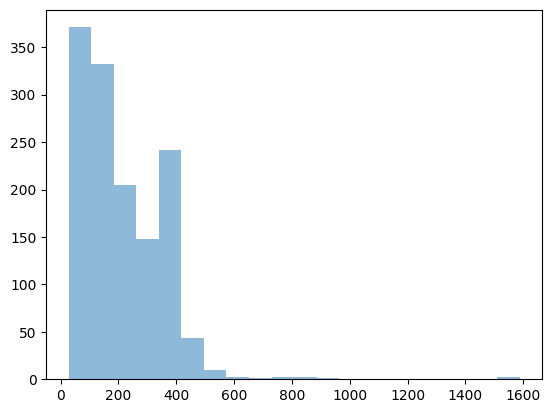

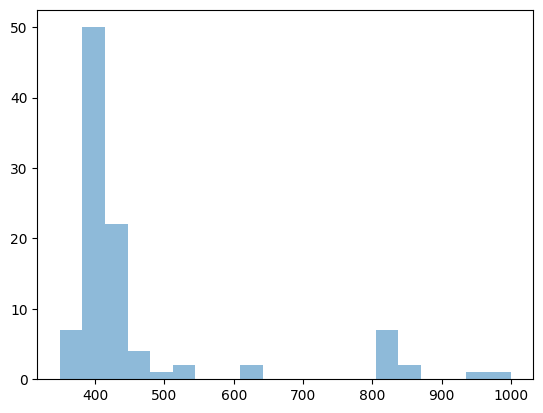

In [125]:
merged_sequence_lengths = [len(seq.seq) for seq in merged_sequences]
protein_sequence_lengths = [len(seq.seq) for seq in protein_sequences]

plt.hist(merged_sequence_lengths, bins=20, alpha=0.5, label='merged_sequence_lengths')
plt.show()
plt.hist(protein_sequence_lengths, bins=20, alpha=0.5, label='protein_sequence_lengths')
plt.show()

# SAVE FASTA

In [114]:
file_location = "merged_exon_sequences.txt"
SeqIO.write(merged_sequences, file_location, "fasta")

1361

### Please note that the sequences from BlastP are from different databases than WGS, hence they don't even have the same IDs, so not easy to compare them

# Just Checking two good sequences to see if they have some alignment

In [130]:
good_merged_seq = merged_sequences[30]
alignment = pairwise2.align.globalxx(good_merged_seq.seq, protein_sequences[0].seq)
print(format_alignment(*alignment[0]))


------KAGQ-LTIVGS-GIA-SINHMTLQAVAC---IETADV---VC-YV-VA-DG-ATEAFIRK--KNE-NCI-DLYPL-YSET----KE-R--TD-TYIQMAEVGA*FSCCILCEN*RVLCS*FMLNHVRAG---KN---VVGVFYGHPGVFVC-PT-HRAIY--IARN--EGYRAV-MLPGL-SAEDCLY-ADLG-IDPSTV--GCI-TYEAT-DM-LVYN-R--PLNS-S--SHLVLY-QVGI-VGK-ADFK-FAYDPKEVCVP-GFRFLVVCARLSRSAGW*-NHH--FGK-LI-DRLEL-EYGPD--HT-VVHYIAPIF---PTEE---PVMERFTIGQL-K-----LK-ENSDK--IATI------STFYL-PPKAPSA-KV-SLN----R--EFLRSLNI-A----DS---RDPMTPF--PW-N---PTAA--PYGEREKKVILELESHVPPPGYRPLKKNSGLA-QA----L------EK----L--SL----D--TR--AL---A-AW--KT-D-RKAY-AD-SVSG--LTDD--ER------D--A-----------L--A---SGKH--AQLS--GALK-------G--GWSS---
      |||  |||||  ||  ||..|||||      || |     |  |  |  |  ||||||    ||  ||  |||   |       |  |  |  |  ||       |     |    |    |   ||     |    |||||||||||||  |  |||    ||    |||||  ||||  ||||||  |||  ||||    ||  ||||  |  |    |  |    |  |||||  |||  ||  |||  |           |  |               |    ||  |  ||||  |||    |  ||||||      |      ||    |     |     |  |      ||        ||||  |||   | | 

In [126]:
whole_contig_sequence_iter = SeqIO.parse(whole_contig_sequences_file_name,"fasta")
aligned_sequence_iter = SeqIO.parse(aligned_wgs_sequences_file_name,"fasta")

sub_seq = next(aligned_sequence_iter)
whole_seq = next(whole_contig_sequence_iter)

protein_of_interest_sequence = Seq("""MESSTQTKPGSLIVVGTGIESIGQMTLQALSYIEAASKVFYCVIDPATEAFILTKNKNCVDLYQYYDNGKSRMDTYTQMAELMLKEVRNGLDVVGVFYGHPGVFVNPSHRALAIARSEGYQARMLPGVSAEDCLFADLCIDPSNPGCLTYEASDFLIRERPVNVHSHLILFQVGCVGIADFNFSGFDNSKFTILVDRLEQEYGPDHTVVHYIAAMMPHQDPVTDKFTIGQLREPEIAKRVGGVSTFYIPPKARKDINTDIIRLLEFLPAGKVPDKHTQIYPPNQWEPDVPTLPPYGQNEQAAITRLEAHAPPEEYQPLATSKAMTDVMTKLALDPKALAEYKADHRAFAQSVPDLTPQERAALELGDSWAIRCAMKNMPSSLLEAASQSVEEASMNGFPWVIVTGIVGVIGSVVSSA""")
#It would seem this sequence is slightly different to that of the papers sequence (the macrocycle sequence isn't the same)
macrocycle_sequence = Seq("WVIVTGIVGVIG")

In [8]:
def get_pos(sub_seq):#takes in a large sequence and returns the start and 
    #end positions of the subsequence in the bigger one
    position = sub_seq.id.split(":")[1]
    start_pos = 0
    end_pos = 0
    if("c" in position):
        start_pos = int(position.split("-")[0][1:])
        end_pos = int(position.split("-")[1])
    else:
        start_pos = int(position.split("-")[0])
        end_pos = int(position.split("-")[1])

    return (start_pos,end_pos)
    
print("location of subsequence",get_pos(sub_seq))
print(sub_seq.seq)
pos = get_pos(sub_seq)
size = abs(pos[0]-pos[1])
print(size, len(sub_seq.seq))
print(whole_seq.seq[18915-20*3:19937].reverse_complement())#I've added 30 bases

print(whole_seq.seq[18915-20*3:19937].reverse_complement().translate())
alignment = pairwise2.align.globalxx(whole_seq.seq[18915-20*3:19937].reverse_complement().translate(), protein_of_interest_sequence)
print(format_alignment(*alignment[0]))
chunked_sequence = whole_seq.seq[18915-20*3:19937].reverse_complement().translate()


location of subsequence (19937, 18915)
CTCATGCTCAAGGAAGTCCGCAATGGCCTCGACGTTGTCGGGGTATTCTATGGCCATCCGGGCGTGTTCGTGAACCCTTCTCACAGGGCATTGGCTATCGCCAGAAGCGAGGGATACCAAGCTCGTATGCTTCCAGGAGTATCTGCAGAGGACTGCCTCTTTGCCGACTTATGCATCGACCCCTCGAACCCCGGCTGCTTGACCTACGAAGCATCCGATTTCCTCATCAGAGAGAGACCAGTGAACGTTCACAGTCACCTCATTCTTTTCCAAGTTGGATGCGTCGGTATCGCAGACTTCAATTTCAGCGGATTCGACGTAAGGATTTTTCCATCCTGTAATGGTCGATCGATTTGTGTCTAACACGTTTAACTTTTCTTTTAGAATTCGAAATTTACCATTCTGGTTGACCGTCTCGAGCAAGAATACGGCCCAGACCATACCGTCGTGCATTATATCGCAGCTATGATGCCTCACCAAGATCCCGTCACCGACAAGTTCACGATCGGACAACTCCGTGAACCCGAAATCGCCAAACGAGTAGGTGGTGTTTCGACTTTTTACATCCCTCCAAAGGCCAGAAAGGATATCAACACCGATATCATCCGACTCTTGGAATTCCTACCTGCTGGTAAAGTTCCCGACAAACACACCCAAATCTACCCACCTAATCAATGGGAACCCGACGTGCCTACTCTACCTCCCTATGGACAAAACGAACAGGCTGCTATCACTAGATTGGAAGCTCACGCTCCCCCCGAAGAGTATCAGCCTCTGGCCACTTCCAAAGCTATGACTGACGTCATGACCAAACTAGCTTTGGATCCCAAGGCGCTCGCCGAGTATAAGGCTGATCATCGAGCCTTCGCTCAGTCTGTTCCTGACTTGACGCCTCAAGAGAGAGCAGCTTTGGAGCTAGGAGATTCATGGGCTATTCGGTGCGCCATGAAGAACATGCCGT

In [9]:
whole_seq = next(whole_contig_sequence_iter)

In [20]:
def get_subseqs_for_whole_seq(whole_seq):
    sequences = get_sequences(aligned_wgs_sequences_file_name)
    parsed_sequences = parse_ids(sequences)
    sequence_dict = create_seq_dict(parsed_sequences)
    id_of_interest = whole_seq.id.split(":")[0]
    #print(sequence_dict.items())
    return sequence_dict[id_of_interest]


sub_seq = get_subseqs_for_whole_seq(whole_seq)[0]
sub_seq.id = sub_seq.name
print(sub_seq.id)

pos = get_pos(sub_seq)
size = abs(pos[0]-pos[1])
print(pos)

print(sub_seq.seq)
print()
alignment = pairwise2.align.globalms(sub_seq.seq.translate(), protein_of_interest_sequence,2,-1,-5,-0.1)#gap penalty of -5 seems to work well at preventing them from forming!
print(format_alignment(*alignment[0]))
print()

chopped_whole_seq = whole_seq[pos[0]-1:]
translated_whole_seq = chopped_whole_seq.translate()
print("extended whole seq")
print(translated_whole_seq.seq[:510])
print()
print("Whole allignement",len(translated_whole_seq.seq))
alignment = pairwise2.align.globalms(translated_whole_seq.seq[:500], protein_of_interest_sequence,2,-1,-5,-0.1)
print(format_alignment(*alignment[0]))
#print(whole_seq.id)
#print(chopped_whole_seq.seq)

RCHF01001239.1:4082-5398
(4082, 5398)
ATGGAATCTTCTGCTCAACCCAAAGCTGGATCGCTCACCATCGTCGGTACAGGTATCGAGAGCATCGGTCAGATGACGCTCCAGGCCTTATCGTACATCGAAGCCGCATCCAAAGTCTTCTACTGCGTCATCGACCCTGCGACTGAGGCTTTCATCCTCACTAAGAACAAGGACTGTGTCGACTTGTATCAGTACTATGATAACGGCAAATCCAGAATGGATACCTATACCCAAATGGCCGAGGTATGAAGCGCCCACCTTTAATTCCGTTCCAGGGACTCGCGCTGATGTATCTGTAGCTCATGCTTAGGGAAGTTCGAAACGGTCTCGATGTTGTTGGGGTATTCTATGGCCACCCAGGCGTGTTCGTGAACCCTTCGCACCGAGCACTATCGATCGCCAGAAGCGAGGGATACCGAGCACGTATGTTGCCAGGAGTGTCTGCCGAGGACTGTCTCTTTGCCGACTTGTGCATTGATCCCTCGAACCCCGGCTGCCTGACCTACGAGGCATCCGATTTCCTCATCAGGGAAAGGCCAGTGAACATTCACAGTCACTTGGTTCTCTTCCAAGTCGGATGTGTCGGTATTGCGGACTTTAACTTTAGCGGATTCGACGTAAGTATATCACCCGACTATCGTACAAGTATTTTCATCTAATAATCTTACCTGTGCAAAGAACTCGAAATTCAACGTGTTGGTTGAACGCCTCGAGCAGGAGTACGGGCCAGACCATACCGTCGTGCACTACATTGCCGCCATGATGCCTCACCAGGATCCTGTCACCGACAAATTCACGATCGGGCAGCTGCGCGAACCTGAAATTGCGAAGCGCGTAGGCGGTGTTTCGACTTTCTACATCCCCCCGAAGGCCAGAAAGGACATCAACACCGACATCATTCGTCTCCTAGAGTTCTTGCCTGCCGGGAAAGTTCCCGACAAACACACTCAGATCTACCCGCC

In [190]:
whole_seq = next(whole_contig_sequence_iter)
sub_seq = get_subseqs_for_whole_seq(whole_seq)[0]
sub_seq.id = sub_seq.name

In [207]:
#patterns that I tend to see:
#the W tends to be 12 aa before the stop codon
#There tends to be a W succeeded by a G around 10-20 afterwards. I think this is the RiPP core peptide
#VM(maybe L) tend to appear after stop codons, potentially something to do with splicing

def print_alignment(seq1,seq2):
    alignment = pairwise2.align.globalms(seq1, seq2,2,-1,-3,-0.1)#gap penalty of -5 seems to work well at preventing them from forming!
    print(format_alignment(*alignment[0]))
    
def get_protein_sequence_till_termination(sub_seq,whole_seq,POI_seq):
    sub_seq.id = sub_seq.name
    print("Working on Seq,\n",sub_seq.id)
    pos = get_pos(sub_seq)
    size = abs(pos[0]-pos[1])
    #print("Sequence pos,\n", pos)
    #print("\nAlignment of Sub Sequence with POI")
    #print_alignment(sub_seq.seq.translate(), protein_of_interest_sequence)
    #print()
    chopped_whole_seq = ""
    if(pos[0]<pos[1]):
        #print("sequence is in correct frame")
        chopped_whole_seq = whole_seq[pos[0]-1:]
    else:
        #print("Sequence is in reverse, REVERSING")
        whole_seq_len = len(whole_seq.seq)
        chopped_whole_seq = copy.deepcopy(whole_seq)
        chopped_whole_seq.seq = whole_seq.seq.reverse_complement()[whole_seq_len-pos[0]:]
    
    #print(chopped_whole_seq)
    max_protein_size = 2000
    translated_whole_seq = copy.deepcopy(chopped_whole_seq)
    translated_whole_seq.seq = chopped_whole_seq.seq[:max_protein_size*3].translate()
    unaligned_start_pos = int((size+1)/3)
    protein_window = unaligned_start_pos+500
    #print("\nTranslated Whole_Seq:\n{}".format(translated_whole_seq.seq[:protein_window]))

    stop_codon_positions = [i for i, char in enumerate(translated_whole_seq.seq) if char == '*' and i>unaligned_start_pos]
    #print("\nSTOP CODONS\n{}".format(stop_codon_positions))
    results = []
    #translated_whole_seq = translated_whole_seq[:stop_codon_pos]
    if(len(stop_codon_positions)==0):
        print("ERROR, whole sequence didn't have a stop codon!")
        return results

    for stop_pos in stop_codon_positions:
        ORI_seq = translated_whole_seq[:stop_pos]
        num_recent_stop_codons = len([i for i, char in enumerate(ORI_seq.seq[-60:]) if char == '*'])
        num_v_recent_stop_codons = len([i for i, char in enumerate(ORI_seq.seq[-15:]) if char == '*'])
        
        if(num_recent_stop_codons > 3):
            #print("\nSequence has many recent stop codons, sequence may no longer be in frame")
            if(num_recent_stop_codons >= 5):
                #print("Too many stop codons, likely out of frame. Breaking")
                break
        if(num_v_recent_stop_codons>0):
            #print("\nVery recent stop codon, thus too short an exon to be considered")
            pass
        elif("W" in ORI_seq.seq[-20:-8]):
            #print("\nGot a speedy W")
            if(num_recent_stop_codons <=3):
                results.append((ORI_seq,10-len(results)))#the 10 is the score of this sequence
        else:
            #print("\nW not in terminal sequence")
            if(num_recent_stop_codons <=3):
                results.append((ORI_seq,0-len(results)))
        #print("\n"+ORI_seq.seq)
    
    for i in range(len(results)):
        insert_point = results[i][0].description.find(" ")
        d = results[i][0].description
        results[i][0].description = d[:insert_point] +" Sequence Score: "+str(results[i][1]) + d[insert_point:]
    return results
                
    

results = get_protein_sequence_till_termination(sub_seq,whole_seq,protein_of_interest_sequence)
#print([str(seq.seq) for seq in results if "W" in seq.seq[-20:]])
print([r[0] for r in results])

Working on Seq,
 ASZD01002201.1:c39268-38600
[SeqRecord(seq=Seq('GIHLINSLF*NSKFGILVDRLEKEYGAEHPVVHYIAAMLPHEDPVTDQWTIGQL...SSA'), id='ASZD01002201.1', name='ASZD01002201.1', description='ASZD01002201.1 Sequence Score: 10 Lentinula edodes 135A Contig_2204, whole genome shotgun sequence', dbxrefs=[]), SeqRecord(seq=Seq('GIHLINSLF*NSKFGILVDRLEKEYGAEHPVVHYIAAMLPHEDPVTDQWTIGQL...MNN'), id='ASZD01002201.1', name='ASZD01002201.1', description='ASZD01002201.1 Sequence Score: -1 Lentinula edodes 135A Contig_2204, whole genome shotgun sequence', dbxrefs=[]), SeqRecord(seq=Seq('GIHLINSLF*NSKFGILVDRLEKEYGAEHPVVHYIAAMLPHEDPVTDQWTIGQL...PTM'), id='ASZD01002201.1', name='ASZD01002201.1', description='ASZD01002201.1 Sequence Score: 8 Lentinula edodes 135A Contig_2204, whole genome shotgun sequence', dbxrefs=[]), SeqRecord(seq=Seq('GIHLINSLF*NSKFGILVDRLEKEYGAEHPVVHYIAAMLPHEDPVTDQWTIGQL...NQE'), id='ASZD01002201.1', name='ASZD01002201.1', description='ASZD01002201.1 Sequence Score: -3 Lentinula edodes 13

In [211]:
whole_contig_sequence_iter = SeqIO.parse(whole_contig_sequences_file_name,"fasta")
aligned_sequence_iter = SeqIO.parse(aligned_wgs_sequences_file_name,"fasta")

protein_of_interest_sequence = Seq("""MESSTQTKPGSLIVVGTGIESIGQMTLQALSYIEAASKVFYCVIDPATEAFILTKNKNCVDLYQYYDNGKSRMDTYTQMAELMLKEVRNGLDVVGVFYGHPGVFVNPSHRALAIARSEGYQARMLPGVSAEDCLFADLCIDPSNPGCLTYEASDFLIRERPVNVHSHLILFQVGCVGIADFNFSGFDNSKFTILVDRLEQEYGPDHTVVHYIAAMMPHQDPVTDKFTIGQLREPEIAKRVGGVSTFYIPPKARKDINTDIIRLLEFLPAGKVPDKHTQIYPPNQWEPDVPTLPPYGQNEQAAITRLEAHAPPEEYQPLATSKAMTDVMTKLALDPKALAEYKADHRAFAQSVPDLTPQERAALELGDSWAIRCAMKNMPSSLLEAASQSVEEASMNGFPWVIVTGIVGVIGSVVSSA""")
#It would seem this sequence is slightly different to that of the papers sequence (the macrocycle sequence isn't the same)
macrocycle_sequence = Seq("WVIVTGIVGVIG")
seqs_of_interest = []

for i in range(1000):
    whole_seq = next(whole_contig_sequence_iter)
    sub_seq = get_subseqs_for_whole_seq(whole_seq)[0]
    sub_seq.id = sub_seq.name
    results = get_protein_sequence_till_termination(sub_seq,whole_seq,protein_of_interest_sequence)
    if(len(results) >0):
        seqs_of_interest.append(results[0][0])

file_location = "Shortest_ORI_sequences.txt"
SeqIO.write(seqs_of_interest, file_location, "fasta")

Working on Seq,
 QPKH01003040.1:c19937-18915
Working on Seq,
 RCHF01001239.1:4082-5398
Working on Seq,
 RCHF01000222.1:52335-52991
Working on Seq,
 MRUK01000047.1:c65255-64605
Working on Seq,
 QPKH01001653.1:50428-51684
Working on Seq,
 JAEVFJ010000005.1:c659344-658349
Working on Seq,
 QLPO01012768.1:3523-4131


/usr/local/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Working on Seq,
 JAJKKG010000035.1:c215909-214797
Working on Seq,
 JAJKKQ010000045.1:c101727-100615
Working on Seq,
 VYXO01000008.1:637598-638710
Working on Seq,
 CADCWU010000021.1:4133876-4135015
Working on Seq,
 JAJKLD010000001.1:c630283-629144
Working on Seq,
 WXVI01000659.1:4543-5625
Working on Seq,
 WGOI01001026.1:6495-7577
Working on Seq,
 JABFMN010000574.1:c10034-8952
Working on Seq,
 CADCWY010000001.1:1299238-1300365
Working on Seq,
 JAJKKX010000041.1:51637-52752
Working on Seq,
 CVMT01000002.1:2967057-2968184
Working on Seq,
 CADCXA010000034.1:233418-234533
Working on Seq,
 AHIW01001259.1:10158-10850
Working on Seq,
 QPFQ01000208.1:36362-37615
Working on Seq,
 CABFOC020000061.1:10167-11294
Working on Seq,
 JAJOOW010003001.1:12827-13939
Working on Seq,
 ASZD01002201.1:c39268-38600
Working on Seq,
 ASZE01001713.1:56412-57080
Working on Seq,
 BDGU01000989.1:46873-47541
Working on Seq,
 LDAT01001125.1:c46467-45799
Working on Seq,
 LOHM01000515.1:c58865-58197
Working on Seq,
 JADPM

Working on Seq,
 LVVM01005011.1:c4854-4531
Working on Seq,
 PVYS01009281.1:c14462-13479
Working on Seq,
 LVVM01005480.1:234-1091
Working on Seq,
 PVYO01011769.1:3024-4007
Working on Seq,
 PVYS01007698.1:5764-6360
Working on Seq,
 PVYK01009461.1:c1435-866
Working on Seq,
 PVYF01007145.1:c11523-10540
Working on Seq,
 PVYM01006412.1:225-959
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 JAGPNJ010000008.1:c1487018-1486068
Working on Seq,
 JAGPNJ010000236.1:c10289-9339
Working on Seq,
 JAKOGH010000002.1:177216-178172
Working on Seq,
 JANWGL010005136.1:c24180-23194
Working on Seq,
 LVVM01003559.1:3-755
Working on Seq,
 JAAAIM010000213.1:c44330-43224
Working on Seq,
 JAAAIN010000007.1:c32294-31188
Working on Seq,
 LYZI01000573.1:156-464
Working on Seq,
 LYZI01001299.1:c1706-1401
Working on Seq,
 WSLN01000841.1:337-645
Working on Seq,
 PVXU01014494.1:c3409-2843
Working on Seq,
 PVYG01001382.1:c2747-1887
Working on Seq,
 LYZI01001657.1:56-364
Working on Seq,
 JANFAE010000032.1

Working on Seq,
 CACVKO010000013.1:805189-805512
Working on Seq,
 CACVKQ010000013.1:818056-818379
Working on Seq,
 AOSL01000954.1:c4793-4470
Working on Seq,
 SJDA01000007.1:459266-459646
Working on Seq,
 SJKF01000008.1:c2247085-2246705
Working on Seq,
 PVYU01002398.1:1-396
Working on Seq,
 PVYQ01008246.1:c8252-7326
Working on Seq,
 CVKZ01000013.1:832686-833009
Working on Seq,
 PVYQ01009729.1:c3008-1980
Working on Seq,
 PDUQ01000035.1:281919-282272
Working on Seq,
 PVYU01002925.1:c793-443
Working on Seq,
 CACVKN010000013.1:811809-812132
Working on Seq,
 CACVKL010000013.1:811809-812132
Working on Seq,
 PVYH01007608.1:c7375-6584
Working on Seq,
 PVYE01001169.1:1152-1463
Working on Seq,
 NHNW01000020.1:c103323-102814
Working on Seq,
 PVYM01006440.1:c793-443
Working on Seq,
 PVYQ01003675.1:c355-44
Working on Seq,
 LYZI01001088.1:3543-4013
Working on Seq,
 LYZI01001089.1:143-613
Working on Seq,
 PVYI01009624.1:c3724-2924
Working on Seq,
 PVXY01007686.1:3583-4053
Working on Seq,
 CALYLX010000

Working on Seq,
 PVYT01001229.1:1-651
Working on Seq,
 PVYQ01009580.1:c696-550
Working on Seq,
 LVVM01004460.1:c11968-11621
Working on Seq,
 JAGGAW010027052.1:1572-2405
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 JANAXQ010001371.1:c549-46
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXX01007401.1:945-1184
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXX01009618.1:77-388
Working on Seq,
 PVXU01002334.1:216-833
Working on Seq,
 PVYU01003714.1:c3233-2967
Working on Seq,
 CAJNJQ010002811.1:c3440-2934
Working on Seq,
 PVYO01008107.1:c594-1
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXV01002861.1:c10614-10123
Working on Seq,
 LVVM01006478.1:c6379-5939
Working on Seq,
 PVXY01011521.1:3-401
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYQ01009202.1:123-506
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYH01001443.1:643-927
ERROR, whole sequence didn't have a stop codon

Working on Seq,
 PVYQ01006060.1:4-621
Working on Seq,
 PVYI01008902.1:1418-1786
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYG01005191.1:235-420
Working on Seq,
 PVYS01006230.1:c203-3
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYT01000594.1:c8522-7965
Working on Seq,
 LYZI01001753.1:42-662
Working on Seq,
 PVYM01008453.1:c766-143
Working on Seq,
 PVXY01007263.1:c1523-1305
Working on Seq,
 PVXX01010616.1:c16233-15616
Working on Seq,
 LVVM01005228.1:4338-4952
Working on Seq,
 JAIWPF010000532.1:c13233-12946
Working on Seq,
 PVYH01010842.1:c1609-1016
Working on Seq,
 PVXT01013991.1:3074-3439
Working on Seq,
 PVYD01003225.1:c14609-13953
Working on Seq,
 PVXT01009879.1:321-941
Working on Seq,
 PVYQ01005843.1:80-700
Working on Seq,
 PVYM01007925.1:80-700
Working on Seq,
 PVXX01003650.1:c768-418
Working on Seq,
 PVYT01006169.1:c571-2
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYU01000942.1:c503-3
ERROR, whole sequence didn't 

Working on Seq,
 PVXY01005118.1:c532-23
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYA01018495.1:2-409
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXY01013027.1:2-433
Working on Seq,
 PVYB01021400.1:c145-2
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYI01010367.1:c287-3
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXY01006233.1:65-511
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXY01005922.1:1-318
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYA01016711.1:2009-2155
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXX01003821.1:c3521-3003
Working on Seq,
 PVYU01004313.1:178-561
Working on Seq,
 PVYT01008471.1:178-561
Working on Seq,
 PVXS01022387.1:c3889-3320
Working on Seq,
 PVYH01001115.1:1206-1454
Working on Seq,
 PVXX01001841.1:c329-3
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYD01002684.1:c2753-2250
Working on Se

Working on Seq,
 PVXV01005106.1:c826-596
Working on Seq,
 PVYQ01005259.1:c3464-3186
Working on Seq,
 PVYM01005952.1:c564-1
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYS01002348.1:c839-354
Working on Seq,
 PVYD01003223.1:c839-354
Working on Seq,
 PVXX01007372.1:3-443
Working on Seq,
 PVYM01008804.1:4948-5313
Working on Seq,
 LYZI01002491.1:3-539
Working on Seq,
 PVYA01016739.1:c634-98
Working on Seq,
 PVYB01005350.1:c332-102
Working on Seq,
 PVYH01008979.1:c12027-11875
Working on Seq,
 PVYG01007939.1:c748-383
Working on Seq,
 LVVM01004829.1:6-545
Working on Seq,
 PVXX01008515.1:c1383-985
Working on Seq,
 PVYH01010298.1:c227-3
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYD01003007.1:2244-2495
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVXU01007731.1:c3106-2597
Working on Seq,
 PVYD01006381.1:c241-2
ERROR, whole sequence didn't have a stop codon!
Working on Seq,
 PVYM01006706.1:c252-121
Working on Seq,
 PVYI01005173.1:c2

802

In [21]:
import time
import datasets
from datasets import Dataset, load_dataset

def slow_fn(sample):
    print(f'starting proc')
    time.sleep(2)
    sample['hash '] = len(sample['seq'])
    print(f'finishing proc')
    return sample

data = [{'seq':'abcd'}]*40

In [22]:
seq_dataset = Dataset.from_list(data)

In [25]:
new_seq_dataset = seq_dataset.map(slow_fn, num_proc=100)

num_proc must be <= 40. Reducing num_proc to 40 for dataset of size 40.
#0:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc



#1:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc




#2:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc


starting proc

#3:   0%|          | 0/1 [00:00<?, ?ex/s]





#4:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc







#5:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc


starting proc

#6:   0%|          | 0/1 [00:00<?, ?ex/s]








#7:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc










#8:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc











#9:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc












#10:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc













#11:   0%|          | 0/1 [00:00<?, ?ex/s]


starting proc













#12:   0%|          | 0/1 [00:00<?, ?ex/s]


starting proc














#13:   0%|          | 0/1 [00:00<?, ?ex/s]


starting proc

#14:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc
















#15:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc


















#16:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc



















#17:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc




















#18:   0%|          | 0/1 [00:00<?, ?ex/s]

starting proc





















 ... (more hidden) ...


starting procstarting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
starting proc
finishing proc


#0: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc



#1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc




#2: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc





#3: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc






#4: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc







#5: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc








#6: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc









#7: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc










#8: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc











#9: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc












#10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc













#11: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc














#12: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc















#13: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc
















#14: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc

















#15: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


















#16: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc



















#17: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc




















#18: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc





















#19: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex][A


finishing proc


#20: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#21: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#22: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#23: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#24: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#27: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#25: 100%|██████████| 1/1 [00:02<00:00,  2.04s/ex]


finishing proc


#28: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#26: 100%|██████████| 1/1 [00:02<00:00,  2.05s/ex]


finishing proc


#29: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#31: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#32: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#33: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#34: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#35: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#36: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#37: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#38: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]


finishing proc


#39: 100%|██████████| 1/1 [00:02<00:00,  2.01s/ex]
